# Lab 2: Clustering

The goal of this lab session is to code a clustering algorithm, apply it to data and compare the performance with other techniques.

You have to send the filled notebook named **"L2_familyname1_familyname2.ipynb"** (groups of 2) by email to aml.centralesupelec.2019@gmail.com by October 9, 2019. Please put **"AML-L2"** in the subject. 

We begin with the standard imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster # all clustering techniques except hdbscan
import warnings
warnings.simplefilter('ignore')
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.45, 's' : 120, 'linewidths':0}

We will have two toy datasets to try the different methods:

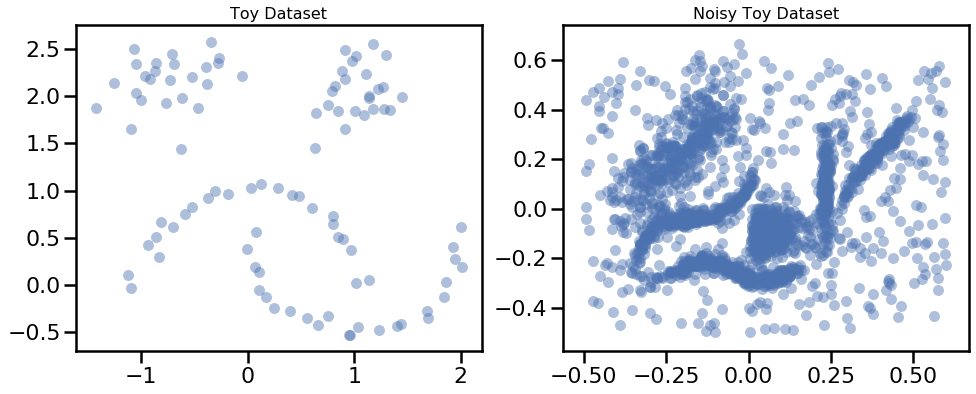

In [2]:
import sklearn.datasets as data
moons, _ = data.make_moons(n_samples=50, noise=0.05)
blobs, _ = data.make_blobs(n_samples=50, centers=[(-0.75,2.25), (1.0, 2.0)], cluster_std=0.25)
test_data_0 = np.vstack([moons, blobs])

test_data_1 = np.load('clusterable_data.npy')

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c='b', **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], color='b', **plot_kwds)
ax[1].set_title('Noisy Toy Dataset', size=16)

plt.show();

There are a lot of clustering algorithms to choose from the `sklearn` library. So what clustering algorithms should you be using? It depends.

## K-means

K-Means is the 'go-to' clustering algorithm for many simply because it is fast, easy to understand, and available everywhere (there's an implementation in almost any statistical or machine learning tool you care to use). However, K-Means has a few problems caused by its simplicity. 

We try the `sklearn` implementation in our toy datasets:

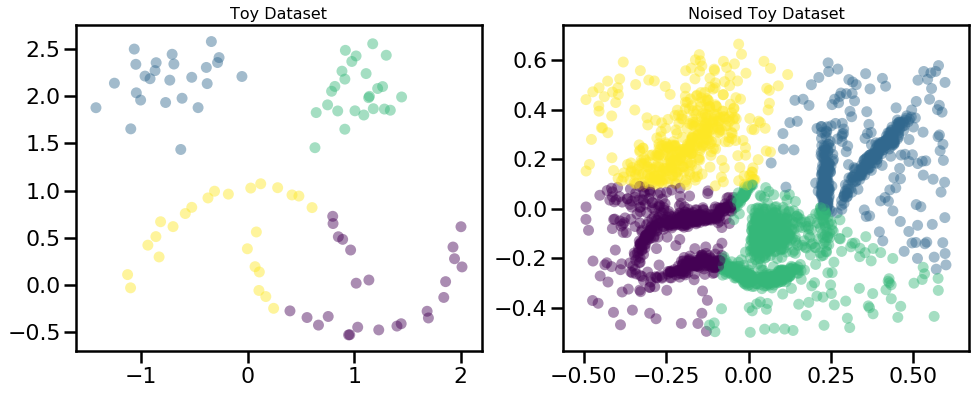

In [3]:
from sklearn.cluster import KMeans
kmeans_0 = KMeans(n_clusters=4, max_iter=200).fit(test_data_0)
kmeans_1 = KMeans(n_clusters=4, max_iter=200).fit(test_data_1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=kmeans_0.labels_ , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=kmeans_1.labels_, **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)


plt.show();

## Aglomerative Single Linkage clustering

Agglomerative clustering is a suite of algorithms all based on the same idea. The fundamental idea is that you start with each point in it's own cluster and then, for each cluster, use some criterion to choose another cluster to merge with. Do this repeatedly until you have only one cluster and you get get a hierarchy, or binary tree, of clusters branching down to the last layer which has a leaf for each point in the dataset. The most basic version of this, single linkage, chooses the closest cluster to merge, and hence the tree can be ranked by distance as to when clusters merged/split.

**Code your own Aglomerative Single Linkage clustering algorithm**!:

- Fill in the class 
- During the process, keep track of the cluster merges by saving a (num_samples-1,4) np.array being a linkage matrix in scypy format (to use their function to plot dendrogram: `scipy.cluster.hierarchy.dendrogram`). check documentation.

In [4]:
from scipy.cluster import hierarchy
from scipy.spatial import distance_matrix 
import pandas as pd 

In [5]:
class my_SingleLinkageAglomerativeClustering():
    
    def __init__(self, metric="euclidean", n_clusters=3, dist = 'min'):
        '''
        Attributes:
        
        metric_: {"euclidean","precomputed"}
            the distance to be used
            if precomputed then X is distance matrix
        n_clusters: integer
            number of clusters to return 
        linkage_matrix_: (n-1, 4) np.array
            in the same format as linkage  
        labels_: integer np.array
            label assigment
        hierarchy_: list of np.array
            each array corresponds to label assigment
            at each level (number of clusters)
            hierarchy_[0]=np.array(list(range(n)))
        '''
        self.metric_ = metric
        self.n_clusters_ = n_clusters
        self.linkage_matrix_ = None
        self.labels_ = None
        self.hierarchy_ = None
        self.dist = dist
        
    def fit(self, X):
        """ Create a hierarchy of clusters
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self: my_SingleLinkageAglomerativeClustering
            to have access to labels_
        """
        
        n_samples = len(X) # nombre d'echantillons
        self.linkage_matrix_ = np.zeros((n_samples - 1, 4))
        self.hierarchy_ = [np.array(range(n_samples))] 
        i = 0
        distance_mat = np.zeros((2*n_samples, 2*n_samples)) ## Taking bigger distance matrix for addition of new vector
        real_dist = distance_matrix(X, X) # On garde les informations sur les distances pour ne pas avoir à les re-calculer
        distance_mat[:n_samples, :n_samples] = real_dist.copy()
        cst = distance_mat.max() + 1 # Les zeros de la matrice de distance seront remplacés par une constante
        distance_mat[distance_mat == 0] = cst
        
        
        while i < n_samples-1 :
            
            # On détermine un index de la distance minimale
            index_min = np.array(np.unravel_index(np.argmin(distance_mat, axis = None), distance_mat.shape))
            
            # Modification des clusters
            new_cluster = self.hierarchy_[-1].copy()
            new_cluster[np.isin(new_cluster, index_min)] = n_samples + i 
            # Les éléments correspondant à la distance minimale sont regroupés dans le même cluster
            real_ind = np.array(np.where(new_cluster ==  n_samples + i)[0])
            self.hierarchy_.append(new_cluster) #On met à jour l'hierarchie
            
            # Update de l'attribut linkage_matrix
            n_points = len(real_ind)
            self.linkage_matrix_[i] = np.array([list(index_min) + [distance_mat[index_min[0], index_min[1]], n_points]])
            
            ## modification de la matrice contenant les distances
            distance_mat[index_min, :], distance_mat[:, index_min] = cst, cst
            # On va distinguer deux types d'indices : 
            
            # - Des indices allant de 0->n correspondants aux échantillons
            index_to_change = np.array(np.where(new_cluster != n_samples + i)[0])
            # - Des indices allant de 0->2n correspondants aux clusters auxquels appartiennent les échantillons
            index_in_distance_mat = new_cluster[index_to_change]
            
            if self.dist == 'max' : ## Nous avons implémenté Single et Complete Linkage
                
                # On calcule ici les distance entre les clusters 
                s = pd.Series(np.max(real_dist[real_ind][:, index_to_change], axis = 0))
                s.index = new_cluster[index_to_change]
                s = s.groupby(level=0).max()
                index_in_distance_mat = np.array(s.index)
                distance_mat[n_samples + i, index_in_distance_mat] = s.values
                
            elif self.dist == 'min' :
                # On calcule ici les distance entre les clusters 
                s = pd.Series(np.min(real_dist[real_ind][:, index_to_change], axis = 0))
                s.index = index_in_distance_mat
                s = s.groupby(level=0).min()
                index_in_distance_mat = np.array(s.index)
                distance_mat[n_samples + i, index_in_distance_mat] = s.values
                
            distance_mat[index_in_distance_mat, n_samples + i] = distance_mat[n_samples + i, index_in_distance_mat]
            
            '''
            ## Nous avons initialisé utilisé une bloucle mais l'algorithme mettait beaucoup de temps à tourner
            ## D'où notre idée de passer par pandas.Series
            
            for k in set(new_cluster):
                if k != n_samples + i:
                    elt_of_class_k = np.where(new_cluster == k)
                    
                    # On calcule la valeur des distances minimales entre la nouvelle classe et les autres
                    distance_mat[n_samples+i, k] =  np.min(real_dist[real_ind][:, elt_of_class_k])
                    distance_mat[k, n_samples+i] =  distance_mat[n_samples+i, k]
            '''
            
            i += 1
            
        self.labels_ = self.hierarchy_[n_samples - self.n_clusters_] 
        
        return None
        
    def plot_dendrogram(self, p = 4):
        '''Use self.linkage_matrix_ in `scipy.cluster.hierarchy.dendrogram` 
        to plot the dendrogram of the hierarchical structure
        '''
        fig, ax = plt.subplots(figsize=(12, 8))
        hierarchy.dendrogram(self.linkage_matrix_, ax=ax,truncate_mode='level', p = p)
        ax.set_title('dendogram with ' + str(self.n_clusters_) + 'clusters')
        return None
        

**TEST SUR LE PREMIER DATA SET**

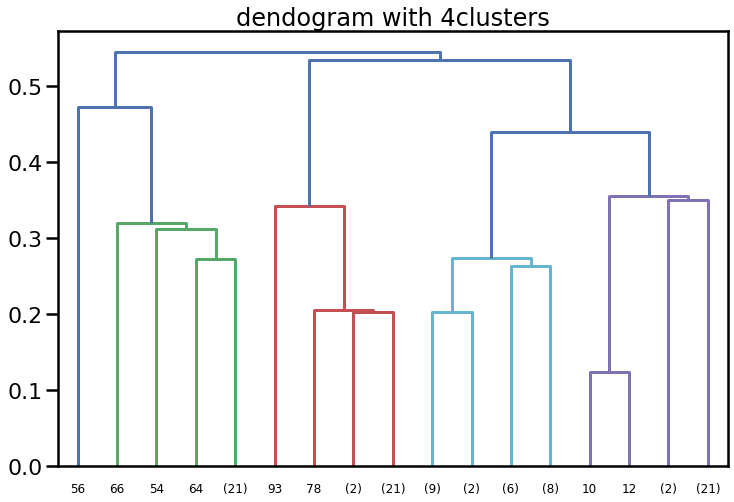

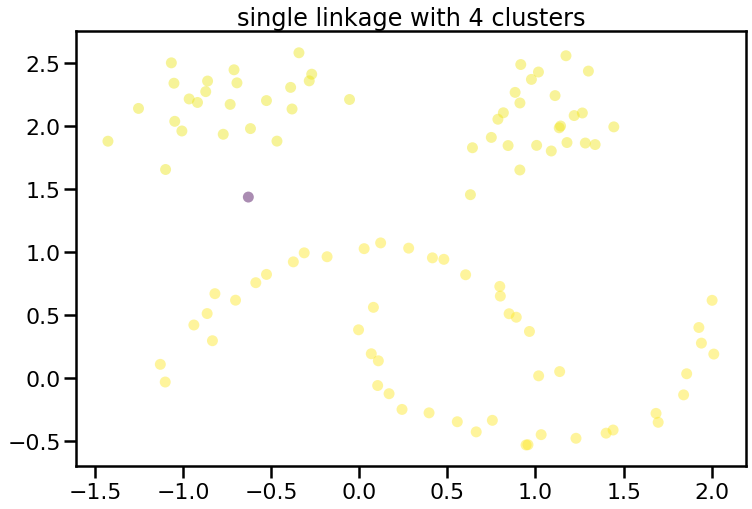

In [6]:
model = my_SingleLinkageAglomerativeClustering(n_clusters=4, dist = 'min')
model.fit(test_data_0)
model.plot_dendrogram()
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.scatter(test_data_0.T[0], test_data_0.T[1], c=model.labels_ , **plot_kwds);
ax.set_title('single linkage with 4 clusters');

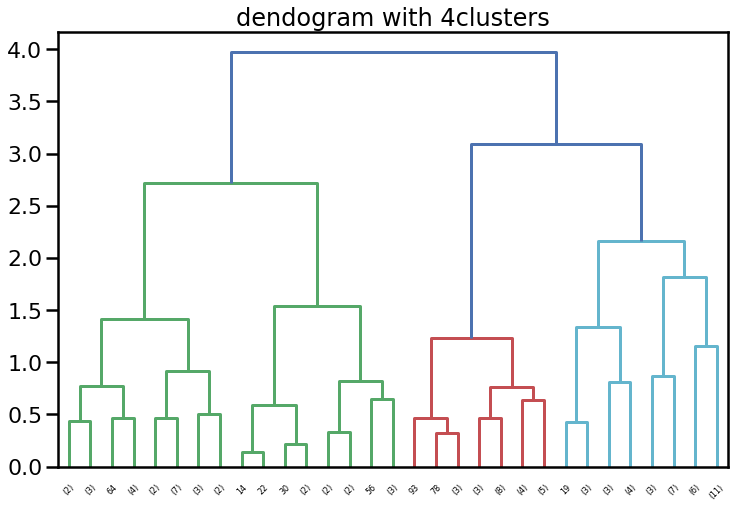

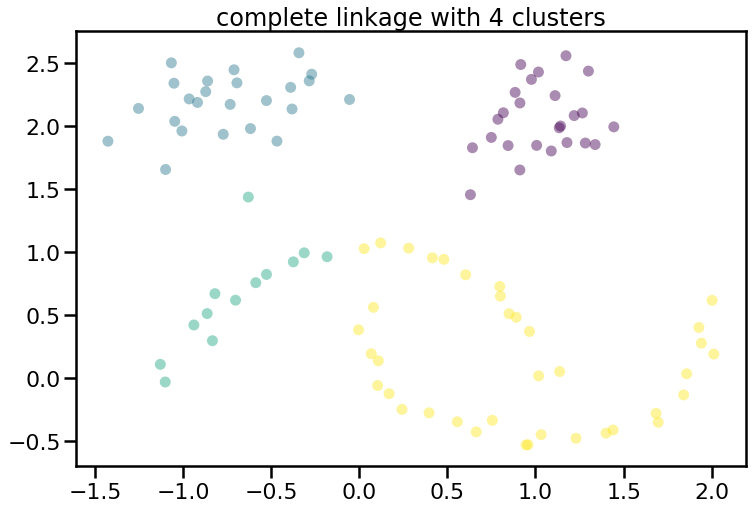

In [7]:
model = my_SingleLinkageAglomerativeClustering(n_clusters=4, dist = 'max')
model.fit(test_data_0)
model.plot_dendrogram()
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.scatter(test_data_0.T[0], test_data_0.T[1], c=model.labels_ , **plot_kwds);
ax.set_title('complete linkage with 4 clusters');

**TEST SUR LE DEUXIEMME DATA SET**

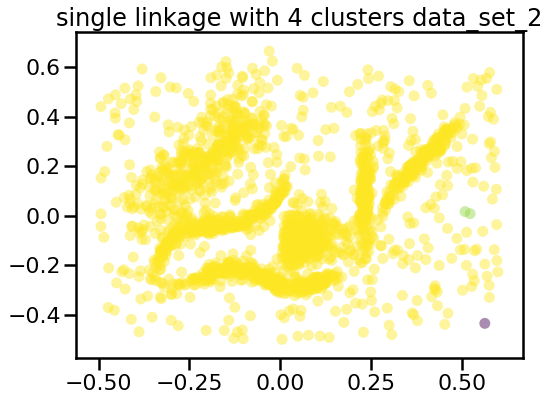

In [8]:
model = my_SingleLinkageAglomerativeClustering(n_clusters=4, dist = 'min')
model.fit(test_data_1)
#model.plot_dendrogram()
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(test_data_1.T[0], test_data_1.T[1], c=model.labels_ , **plot_kwds);
ax.set_title('single linkage with 4 clusters data_set_2');

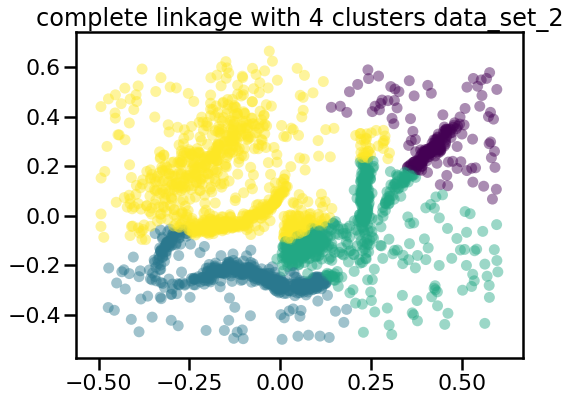

In [9]:
model = my_SingleLinkageAglomerativeClustering(n_clusters=4, dist = 'max')
model.fit(test_data_1)
#model.plot_dendrogram()
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(test_data_1.T[0], test_data_1.T[1], c=model.labels_ , **plot_kwds)
ax.set_title('complete linkage with 4 clusters data_set_2');


Apply the method to our toy datasets

Try the different linkage methods implemented in `sklearn`  and comment

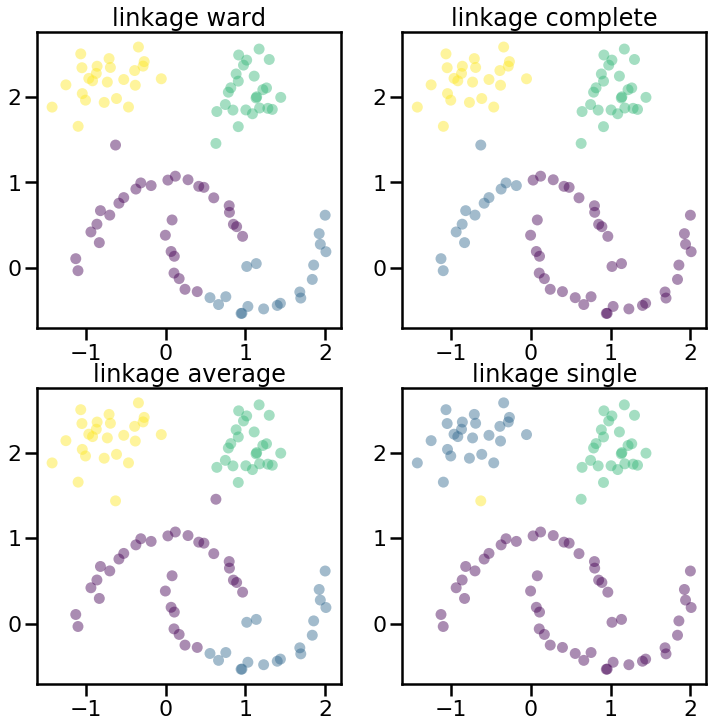

In [10]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

n_clusters = 4
linkages = ['ward', 'complete', 'average', 'single']

fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax = ax.flatten()
for (i, linkage) in enumerate(linkages) :
    model = AgglomerativeClustering(n_clusters=n_clusters,
                                    linkage=linkage, affinity='euclidean')
    model.fit(test_data_0)
    ax[i].scatter(test_data_0.T[0], test_data_0.T[1], c=model.labels_, **plot_kwds)
    ax[i].set_title('linkage ' + linkage)

**DATA_SET 2**

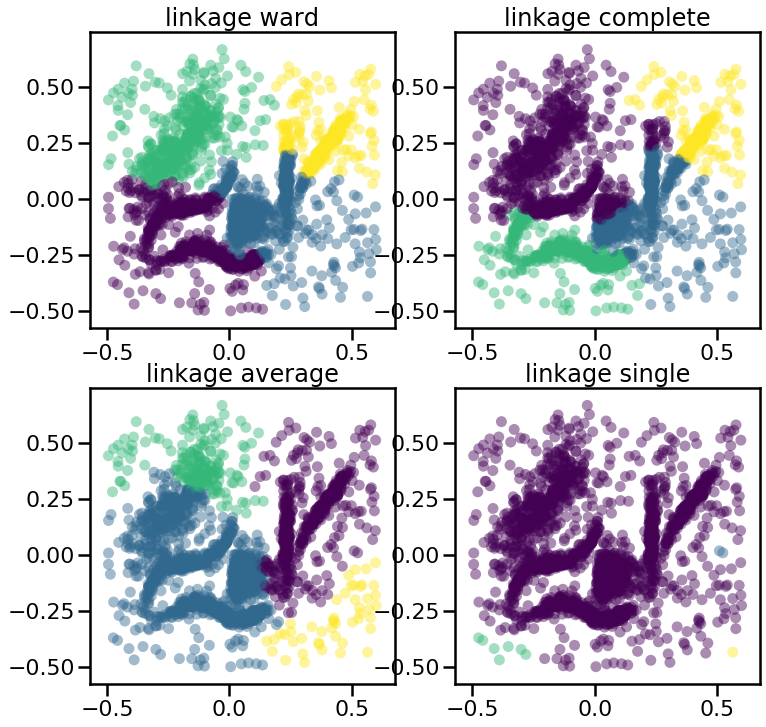

In [11]:
n_clusters = 4
linkages = ['ward', 'complete', 'average', 'single']

fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax = ax.flatten()
for (i, linkage) in enumerate(linkages) :
    model = AgglomerativeClustering(n_clusters=n_clusters,
                                    linkage=linkage, affinity='euclidean')
    model.fit(test_data_1)
    ax[i].scatter(test_data_1.T[0], test_data_1.T[1], c=model.labels_, **plot_kwds)
    ax[i].set_title('linkage ' + linkage)

## DBSCAN

DBSCAN is a density based algorithm -- it assumes clusters for dense regions. It is also the first actual clustering algorithm we've looked at: it doesn't require that every point be assigned to a cluster and hence doesn't partition the data, but instead extracts the 'dense' clusters and leaves sparse background classified as 'noise'. In practice DBSCAN is related to agglomerative clustering. As a first step DBSCAN transforms the space according to the density of the data: points in dense regions are left alone, while points in sparse regions are moved further away. Applying single linkage clustering to the transformed space results in a dendrogram, which we cut according to a distance parameter (called epsilon or `eps` in many implementations) to get clusters. Importantly any singleton clusters at that cut level are deemed to be 'noise' and left unclustered. 

Apply it to the test_data, how do you tune the parameters?

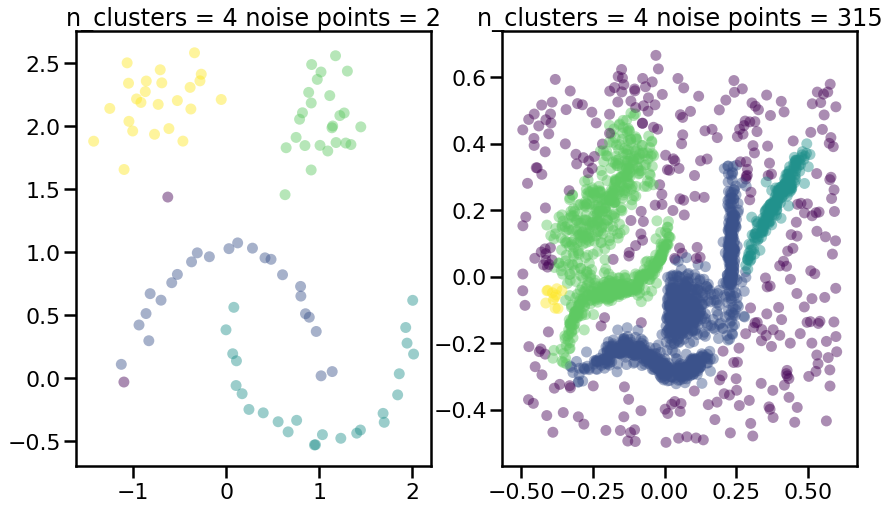

In [12]:
# TODO
from sklearn.cluster import DBSCAN
model = DBSCAN(eps=0.37, min_samples=5)
model.fit(test_data_0)
labels = model.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
fig, ax = plt.subplots(1, 2, figsize=(14, 8))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=labels , **plot_kwds)
ax[0].set_title('n_clusters = ' + str(n_clusters_) + ' noise points = '+ str( n_noise_));

from sklearn.cluster import DBSCAN
model = DBSCAN(eps=0.04, min_samples=12)
model.fit(test_data_1)
labels = model.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=labels , **plot_kwds);
ax[1].set_title('n_clusters = ' + str(n_clusters_) + ' noise points = '+ str( n_noise_));

**Pour l'optimisation des paramètres, il faut tout d'abord fixer min_samples et la valeur d'epsilon est déterminée grace à une analyse des distances entre les points : k_distance_plot**

## HDBSCAN

HDBSCAN is a recent algorithm developed by some of the same people who write the original DBSCAN paper. Their goal was to allow varying density clusters. The algorithm starts off much the same as DBSCAN: we transform the space according to density, exactly as DBSCAN does, and perform single linkage clustering on the transformed space. Instead of taking an epsilon value as a cut level for the dendrogram however, a different approach is taken: the dendrogram is condensed by viewing splits that result in a small number of points splitting off as points 'falling out of a cluster'. This results in a smaller tree with fewer clusters that 'lose points'. That tree can then be used to select the most stable or persistent clusters. This process allows the tree to be cut at varying height, picking our varying density clusters based on cluster stability.

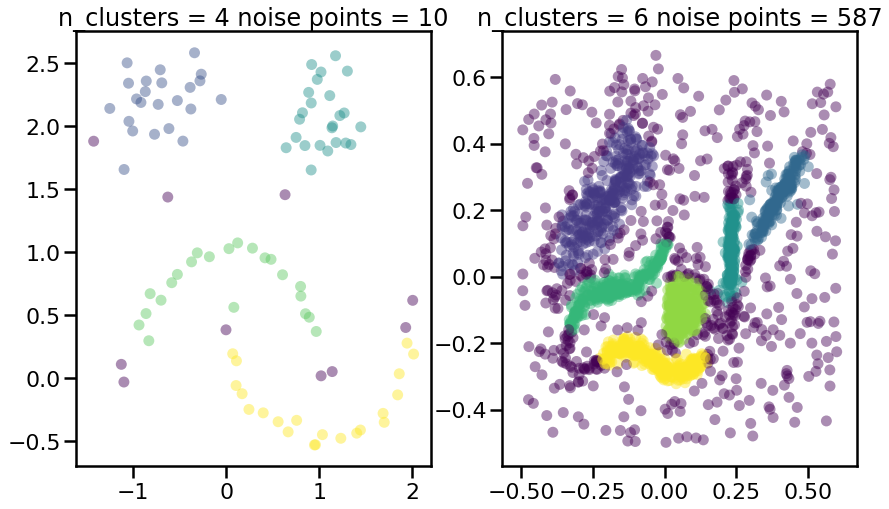

In [13]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
clusterer.fit(test_data_0);
labels = clusterer.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

fig, ax = plt.subplots(1, 2, figsize=(14, 8))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=labels , **plot_kwds);
ax[0].set_title('n_clusters = ' + str(n_clusters_) + ' noise points = '+ str( n_noise_))
# data_set_2

clusterer = hdbscan.HDBSCAN(min_cluster_size=30, gen_min_span_tree=True)
clusterer.fit(test_data_1);
labels = clusterer.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=labels , **plot_kwds)
ax[1].set_title('n_clusters = ' + str(n_clusters_) + ' noise points = '+ str( n_noise_));

## Apply the algorithms to the following images and comment the results

### NASA Curiosity Picture

In [14]:
from scipy import ndimage

- Look at following NASA photo taken by a robot in mars:


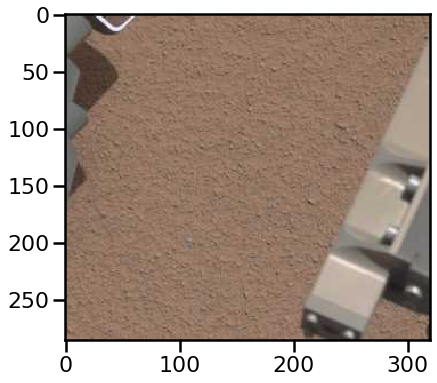

In [15]:
from PIL import Image

Im_1  = Image.open('im_nasa_reduced-1.jpg')

fig = plt.figure(figsize=(8, 6))
plt.imshow(Im_1)
plt.show()

- Transform the image to an intensity (I) and saturation (S) representation, it helps to distinguish bright and textures.

$$I=\frac{R+G+B}{3}$$
$$S=1-I\times min(R, G, B)$$

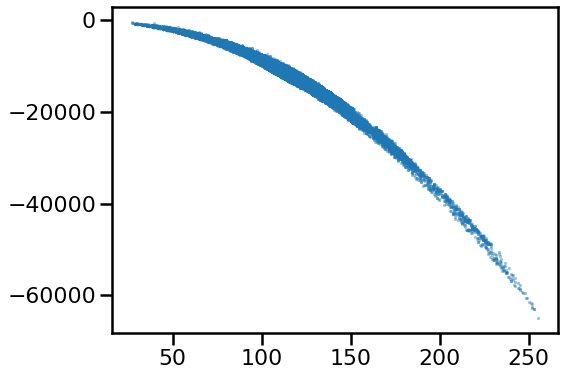

In [16]:
img_ = plt.imread('im_nasa_reduced-1.jpg')
img = img_.reshape(img_.shape[0] * img_.shape[1], 3)
I = np.sum(img, axis = 1)/3
S = 1 - np.min(img, axis = 1)*I
X = np.array([I, S]).T
plot_kwds = {'alpha' : 0.45, 's' : 10, 'linewidths':0}
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(I, S,  **plot_kwds);

- Apply the seen algorithms to segment the image in the Intensity-Saturation representation, comment the results and check if you find something on mars' surface. Be careful with hdbscan and memory errors for some parameters choice (use algorithm='boruvka_kdtree').

In [17]:
from sklearn.preprocessing import StandardScaler

In [18]:
X = StandardScaler().fit(X).transform(X) # we standarsize the date in order to have the same range of values

n_clusters = 57 noise points = 27115


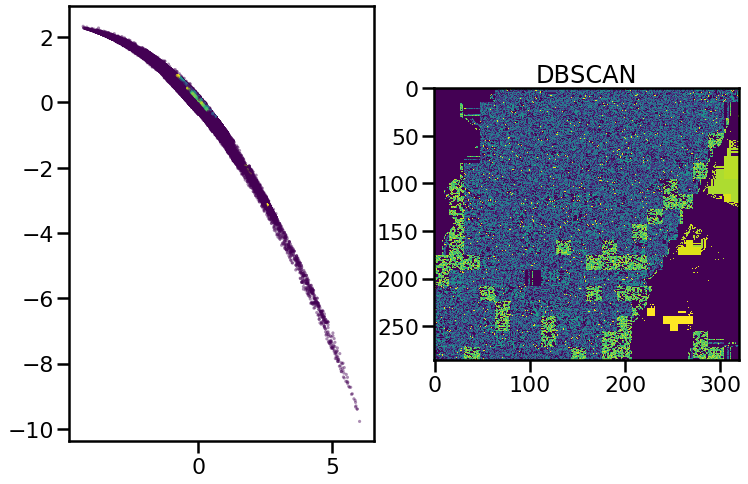

In [19]:
# On commence par tester DBSCAN
from sklearn.cluster import DBSCAN
model = DBSCAN(eps=0.02, min_samples=300)
model.fit(X)
labels = model.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('n_clusters =',n_clusters_, 'noise points =', n_noise_)
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
ax[0].scatter(X.T[0], X.T[1], c=labels , **plot_kwds);
ax[1].imshow(labels.reshape(img_.shape[0], img_.shape[1]))
plt.title('DBSCAN') ;

n_clusters = 236 noise points = 13441


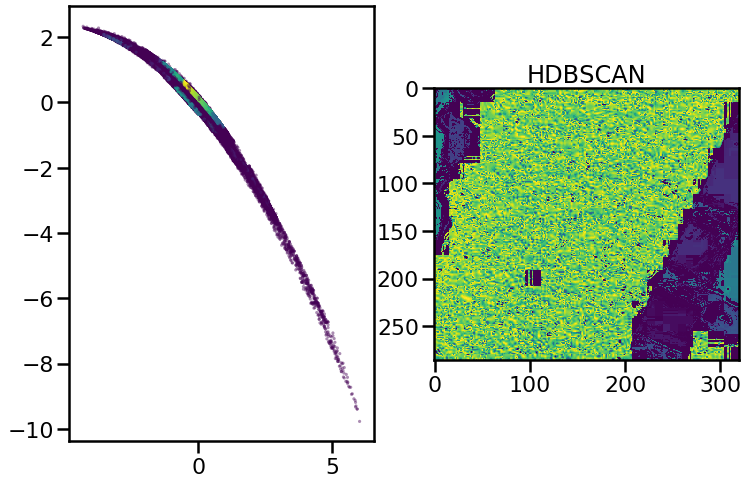

In [20]:
# Ensuite HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=40, gen_min_span_tree=True, algorithm='boruvka_kdtree')
clusterer.fit(X);
labels = clusterer.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('n_clusters =',n_clusters_, 'noise points =', n_noise_)
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
ax[0].scatter(X.T[0], X.T[1], c=labels , **plot_kwds);
ax[1].imshow(labels.reshape(img_.shape[0], img_.shape[1]))
plt.title('HDBSCAN');

**Il semble se trouver sur la surface de Mars des petits résidus...**

### Color compression

One interesting application of clustering is in color compression within images. 
For example, imagine you have an image with millions of colors.
In most images, a large number of the colors will be unused, and many of the pixels in the image will have similar or even identical colors.

Get a simplified 10-colored version of the following image by applying k-means. Plot both images.

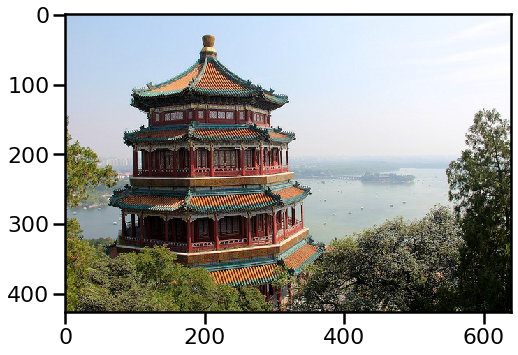

In [21]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")

fig = plt.figure(figsize=(8, 6))
plt.imshow(china);

**PREMIER ESSAI, EN PASSANT PAR LA REPRESENTATION (I, S)**

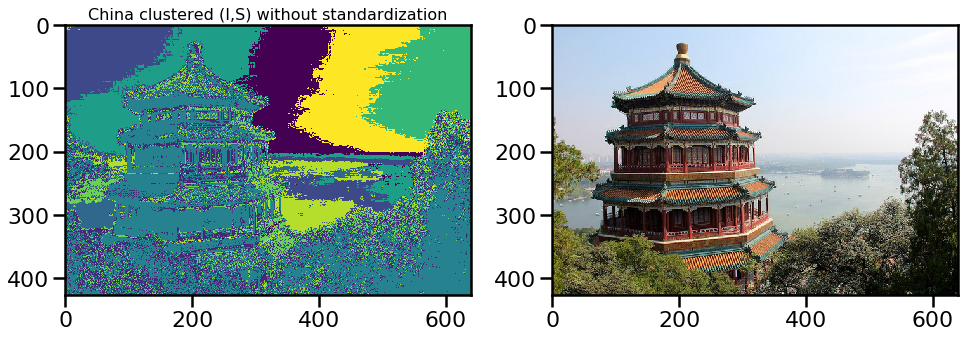

In [22]:
img = china.reshape(china.shape[0]* china.shape[1], 3)
I = np.sum(img, axis = 1)/3
S = 1 - np.min(img, axis = 1)*I
X = np.array([I, S]).T

kmeans = KMeans(n_clusters=10, max_iter=400).fit(X)
labels = kmeans.labels_
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(labels.reshape(china.shape[0], china.shape[1]))
ax[0].set_title('China clustered (I,S) without standardization', size=16)
ax[1].imshow(china)

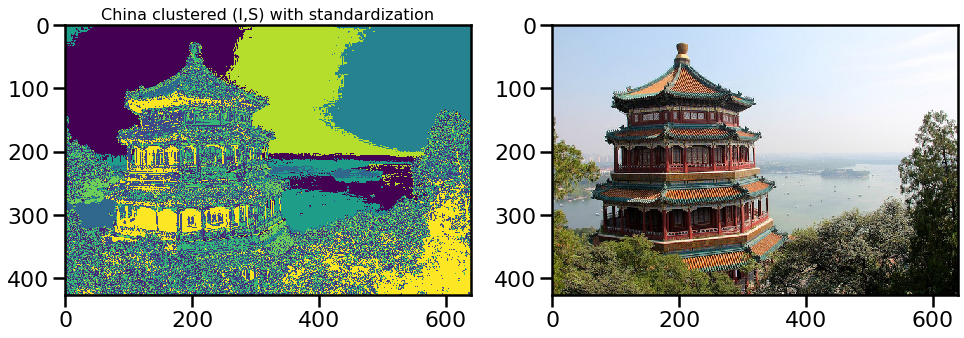

In [23]:
# AVEC STANDARDIZATION DANS LE CAS DE LA REPRESENTATION (I,S)
img = china.reshape(china.shape[0]* china.shape[1], 3)
I = np.sum(img, axis = 1)/3
S = 1 - np.min(img, axis = 1)*I
X = np.array([I, S]).T

X = StandardScaler().fit(X).transform(X)
kmeans = KMeans(n_clusters=10, max_iter=400).fit(X)
labels = kmeans.labels_
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(labels.reshape(china.shape[0], china.shape[1]))
ax[0].set_title('China clustered (I,S) with standardization', size=16)
ax[1].imshow(china)

**2e ESSAI, EN TRAVAILLANT DIRECTEMENT SUR LA DONNÉE BRUTE**

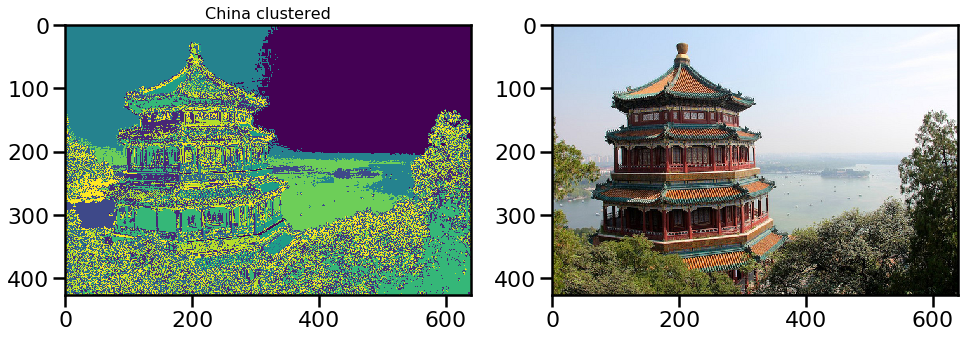

In [24]:
img = china.reshape(china.shape[0]* china.shape[1], 3)
kmeans = KMeans(n_clusters=10, max_iter=400).fit(img)
labels = kmeans.labels_
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(labels.reshape(china.shape[0], china.shape[1]))
ax[0].set_title('China clustered', size=16)
ax[1].imshow(china)